## Introduction
We are ready to train the Cardiac Detection Model now!

## Imports:

* torch and torchvision for model and dataloader creation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* numpy data loading
* cv2 for drawing rectangles on images
* imgaug for augmentation pipeline
* Our CardiacDataset



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root = "/content/drive/My Drive/pytorch_udemy/05-Detection/"

In [ ]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install --upgrade imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%cd /content/drive/My Drive/pytorch_udemy/05-Detection/

/content/drive/My Drive/pytorch_udemy/05-Detection


In [ ]:
import torch
import torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import cv2
import imgaug.augmenters as iaa
from dataset import CardiacDataset


In [ ]:
#create train_subjects.npy and val_subjects.npy
import numpy as np
import pandas as pd


valfile = np.load(root + "Processed-Heart-Detection/val_subjects_det.npy")
print(valfile)


['47f9b094-3b65-45f9-a14c-0a96f4054f5b'
 '4848e1ef-c795-43f9-abf5-3684a918793d'
 '487fa774-01cd-460c-8a32-8382f995c2e5'
 '4986ae7e-9aa0-4aba-97cd-771ced0551e6'
 '49cda5b8-d41d-4b34-b25b-b92520b65ea5'
 '4ad972a8-8778-4e3a-bb42-947c55a8944c'
 '4b9dced6-3164-4811-bf8c-242400da9ac4'
 '4bea6d01-164a-4cf1-880f-7d5050481f3a'
 '4c49b00e-e7e7-4deb-9097-5db5e3804585'
 '4c550090-ae85-4117-91a2-1c2976c9bc11'
 '4c52f9c5-6ce0-4e28-ae5d-ddb37f374f31'
 '4cf82164-6678-4864-bbc4-5a93419424f7'
 '4d67f8f8-2b08-466a-803f-6e70743b30e4'
 '4db6986d-c092-4c1a-957a-6149d8a91d7c'
 '3d983044-375b-4642-85ce-911e7595b54f'
 '3df0327c-2a52-4e32-ac15-1f0d287a9744'
 '3f189f11-c1f4-47a9-a1b0-886fb7344bc1'
 '3f243895-e345-42b7-998c-2f62a77836fd'
 '400ca4f8-95cc-4c78-acbc-c86ec651ffef'
 '409068f6-5a47-4048-82ae-4a8a2a0ee711'
 '40f55d75-0e89-4392-a32c-84ff66530a4a'
 '410ba4b1-4c3c-467e-b58e-838ded07e266'
 '414e4a00-bec4-4552-92d3-7e710b367869'
 '429fb0ce-b3ec-456d-821e-49969d2c54a0'
 '42f5e5df-738c-429c-a811-93f2486dad67'


We create the dataset objects and the augmentation parameters to specify the augmentation parameters

In [ ]:
train_root_path = root + "Processed-Heart-Detection/train/"
train_subjects = root + "Processed-Heart-Detection/train_subjects_det.npy"
val_root_path = root + "Processed-Heart-Detection/val/"
val_subjects = root + "Processed-Heart-Detection/val_subjects_det.npy"

train_transforms = iaa.Sequential([
                                iaa.GammaContrast(),
                                iaa.Affine(
                                    scale=(0.8, 1.2),
                                    rotate=(-10, 10),
                                    translate_px=(-10, 10)
                                )
                            ])

In [ ]:
train_dataset = CardiacDataset("/content/drive/My Drive/pytorch_udemy/05-Detection/rsna_heart_detection.csv", train_subjects, train_root_path, train_transforms)
val_dataset = CardiacDataset("/content/drive/My Drive/pytorch_udemy/05-Detection/rsna_heart_detection.csv", val_subjects, val_root_path, None)

In [ ]:
batch_size = 8
num_workers = 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
train_dataset = CardiacDataset(
    "/content/drive/My Drive/pytorch_udemy/05-Detection/rsna_heart_detection.csv",
     train_subjects,
     train_root_path,
     augs = train_transforms)

val_dataset = CardiacDataset(
    "/content/drive/My Drive/pytorch_udemy/05-Detection/rsna_heart_detection.csv",
     val_subjects,
     val_root_path,
     augs=None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 400 train images and 89 val images


Adapt batch size and num_workers according to your computing hardware.

In [ ]:
batch_size = 8#TODO
num_workers = 4# TODO


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Creation

We use the same architecture as we used in the classifcation task with some small adaptations:

1. 4 outputs: Instead of predicting a binary label we need to estimate the location of the heart (xmin, ymin, xmax, ymax).
2. Loss function: Instead of using a cross entropy loss, we are going to use the L2 loss (Mean Squared Error), as we are dealing with continuous values.

In [ ]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18(pretrained=True)
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512 ,out_features=4)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()
        
    def forward(self, data):
        return self.model(data)
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Train Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)
        
        self.log("Val Loss", loss)
        
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss
    
    def log_images(self, x_ray, pred, label, name):
        results = []
        
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]
            
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item() #extract scalar with .item 
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)
            
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)
            
            results.append(torch.tensor(img).unsqueeze(0))
        
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(name, grid, self.global_step)
        
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [ ]:
# Create the model object
model = CardiacDetectionModel()  # Instanciate the model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

Train for at least 50 epochs to get a decent result.
100 epochs lead to great results.

You can train this on a CPU!

In [ ]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger("/content/drive/My Drive/pytorch_udemy/05-Detection/logs/"), log_every_n_steps=1, callbacks=checkpoint_callback, max_epochs=100)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%cd /content/drive/My Drive/pytorch_udemy/05-Detection/logs/lightning_logs/version_1/checkpoints/

/content/drive/My Drive/pytorch_udemy/05-Detection/logs/lightning_logs/version_1/checkpoints


## Evaluation

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.load_from_checkpoint("/content/drive/My Drive/pytorch_udemy/05-Detection/logs/lightning_logs/version_1/checkpoints/epoch=97-step=4900.ckpt")
model.eval();
model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CardiacDetectionModel(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tru

Compute prediction for all validation samples

In [ ]:
preds = []
labels = []


with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds=torch.stack(preds)
labels=torch.stack(labels)

Compute mean deviation between prediction and labels for each coordinate

In [ ]:
abs(preds-labels).mean(0) #these are the pixel differents of each coordinate of the bounding box between the predicted and the ground truth

tensor([5.1884, 4.0917, 4.6837, 6.3372])

Example prediction:

tensor([ 88,  67, 164, 171])


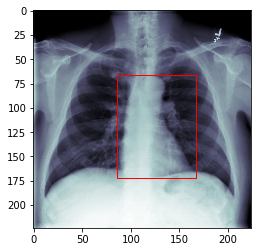

In [ ]:
IDX = 10  # Feel free to inspect all validation samples by changing the index
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')
axis.add_patch(heart)

print(label)

Awesome, looks like we got a working heart detection!